In [1]:
from pathlib import Path
import rioxarray
import geopandas as gpd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

import dask

from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
path_img = Path("test_data/test_image_1210x718.tif")
path_positive_label = Path("test_data/test_image_labels_positive_1210x718.gpkg")
path_negative_label = Path("test_data/test_image_labels_negative_1210x718.gpkg")

In [3]:
img = rioxarray.open_rasterio(path_img, chunks = {"band": 1, "x": 1024, "y": 1024})
gpd_positive = gpd.read_file(path_positive_label).to_crs(img.rio.crs)
gpd_negative = gpd.read_file(path_negative_label).to_crs(img.rio.crs)

## Investigate the data

/tmp/ipykernel_9964/2710702200.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_9964/2710702200.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


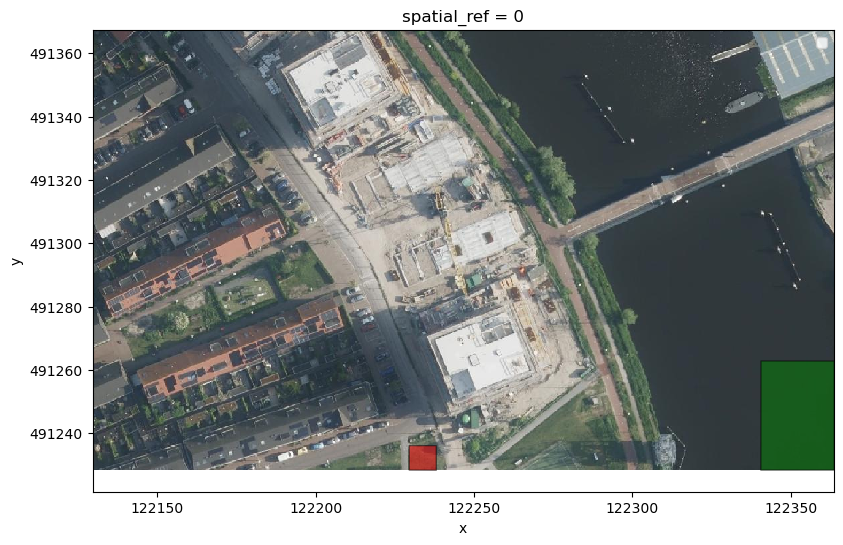

/home/oku/miniforge3/envs/rsdat_2025/lib/python3.10/site-packages/rasterio/features.py:392: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
img.plot.imshow(ax=ax)
gpd_positive.plot(ax=ax, color='green', alpha=0.5, edgecolor='k', label='Positive')
gpd_negative.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Negative')
ax.legend()

## Build training data

In [5]:
#Positive labels
labels_template_pos = xr.full_like(img.isel(band=0).drop_vars("band"), fill_value=1, dtype=np.int32)
labels_template_pos = labels_template_pos.rio.write_nodata(-1)
pos_label_array = xr.map_blocks(
                lambda raster, geom: raster.rio.clip(geom, drop=False),
                labels_template_pos,
                args=(gpd_positive['geometry'],),
                template=labels_template_pos,
            )

In [6]:
#Negative labels
labels_template_neg = xr.full_like(img.isel(band=0).drop_vars("band"), fill_value=0, dtype=np.int32)
labels_template_neg = labels_template_neg.rio.write_nodata(-1)
neg_label_array = xr.map_blocks(
                lambda raster, geom: raster.rio.clip(geom, drop=False),
                labels_template_neg,
                args=(gpd_negative['geometry'],),
                template=labels_template_neg
            )

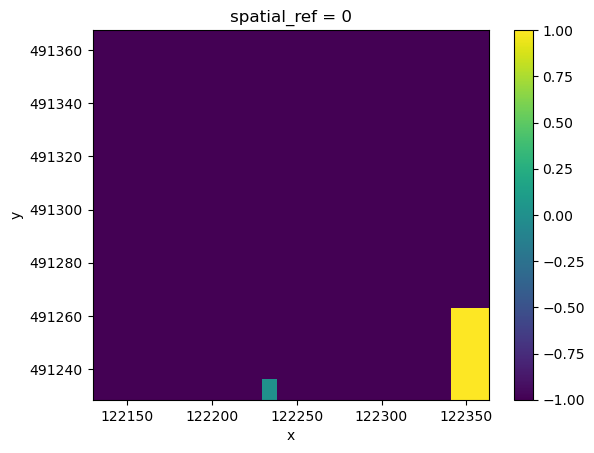

In [7]:
labels = -(pos_label_array * neg_label_array)
labels.plot.imshow(vmin=-1, vmax=1)

In [8]:
def prepare_training_data(input_data, labels):
    # Reshape input data to [n_instances, n_features]
    flattened = labels.flatten()
    positive_data = input_data.reshape((input_data.shape[0], -1))[:, flattened == 1].transpose()
    negative_data = input_data.reshape((input_data.shape[0], -1))[:, flattened == 0].transpose()
    positive_labels = np.full_like(positive_data, 1)
    negative_labels = np.full_like(negative_data, 0)
    train_data = np.concatenate((positive_data, negative_data))
    train_labels = np.concatenate((positive_labels, negative_labels))

    return train_data, train_labels

In [9]:
train_data, train_labels = prepare_training_data(img.data, labels.data)

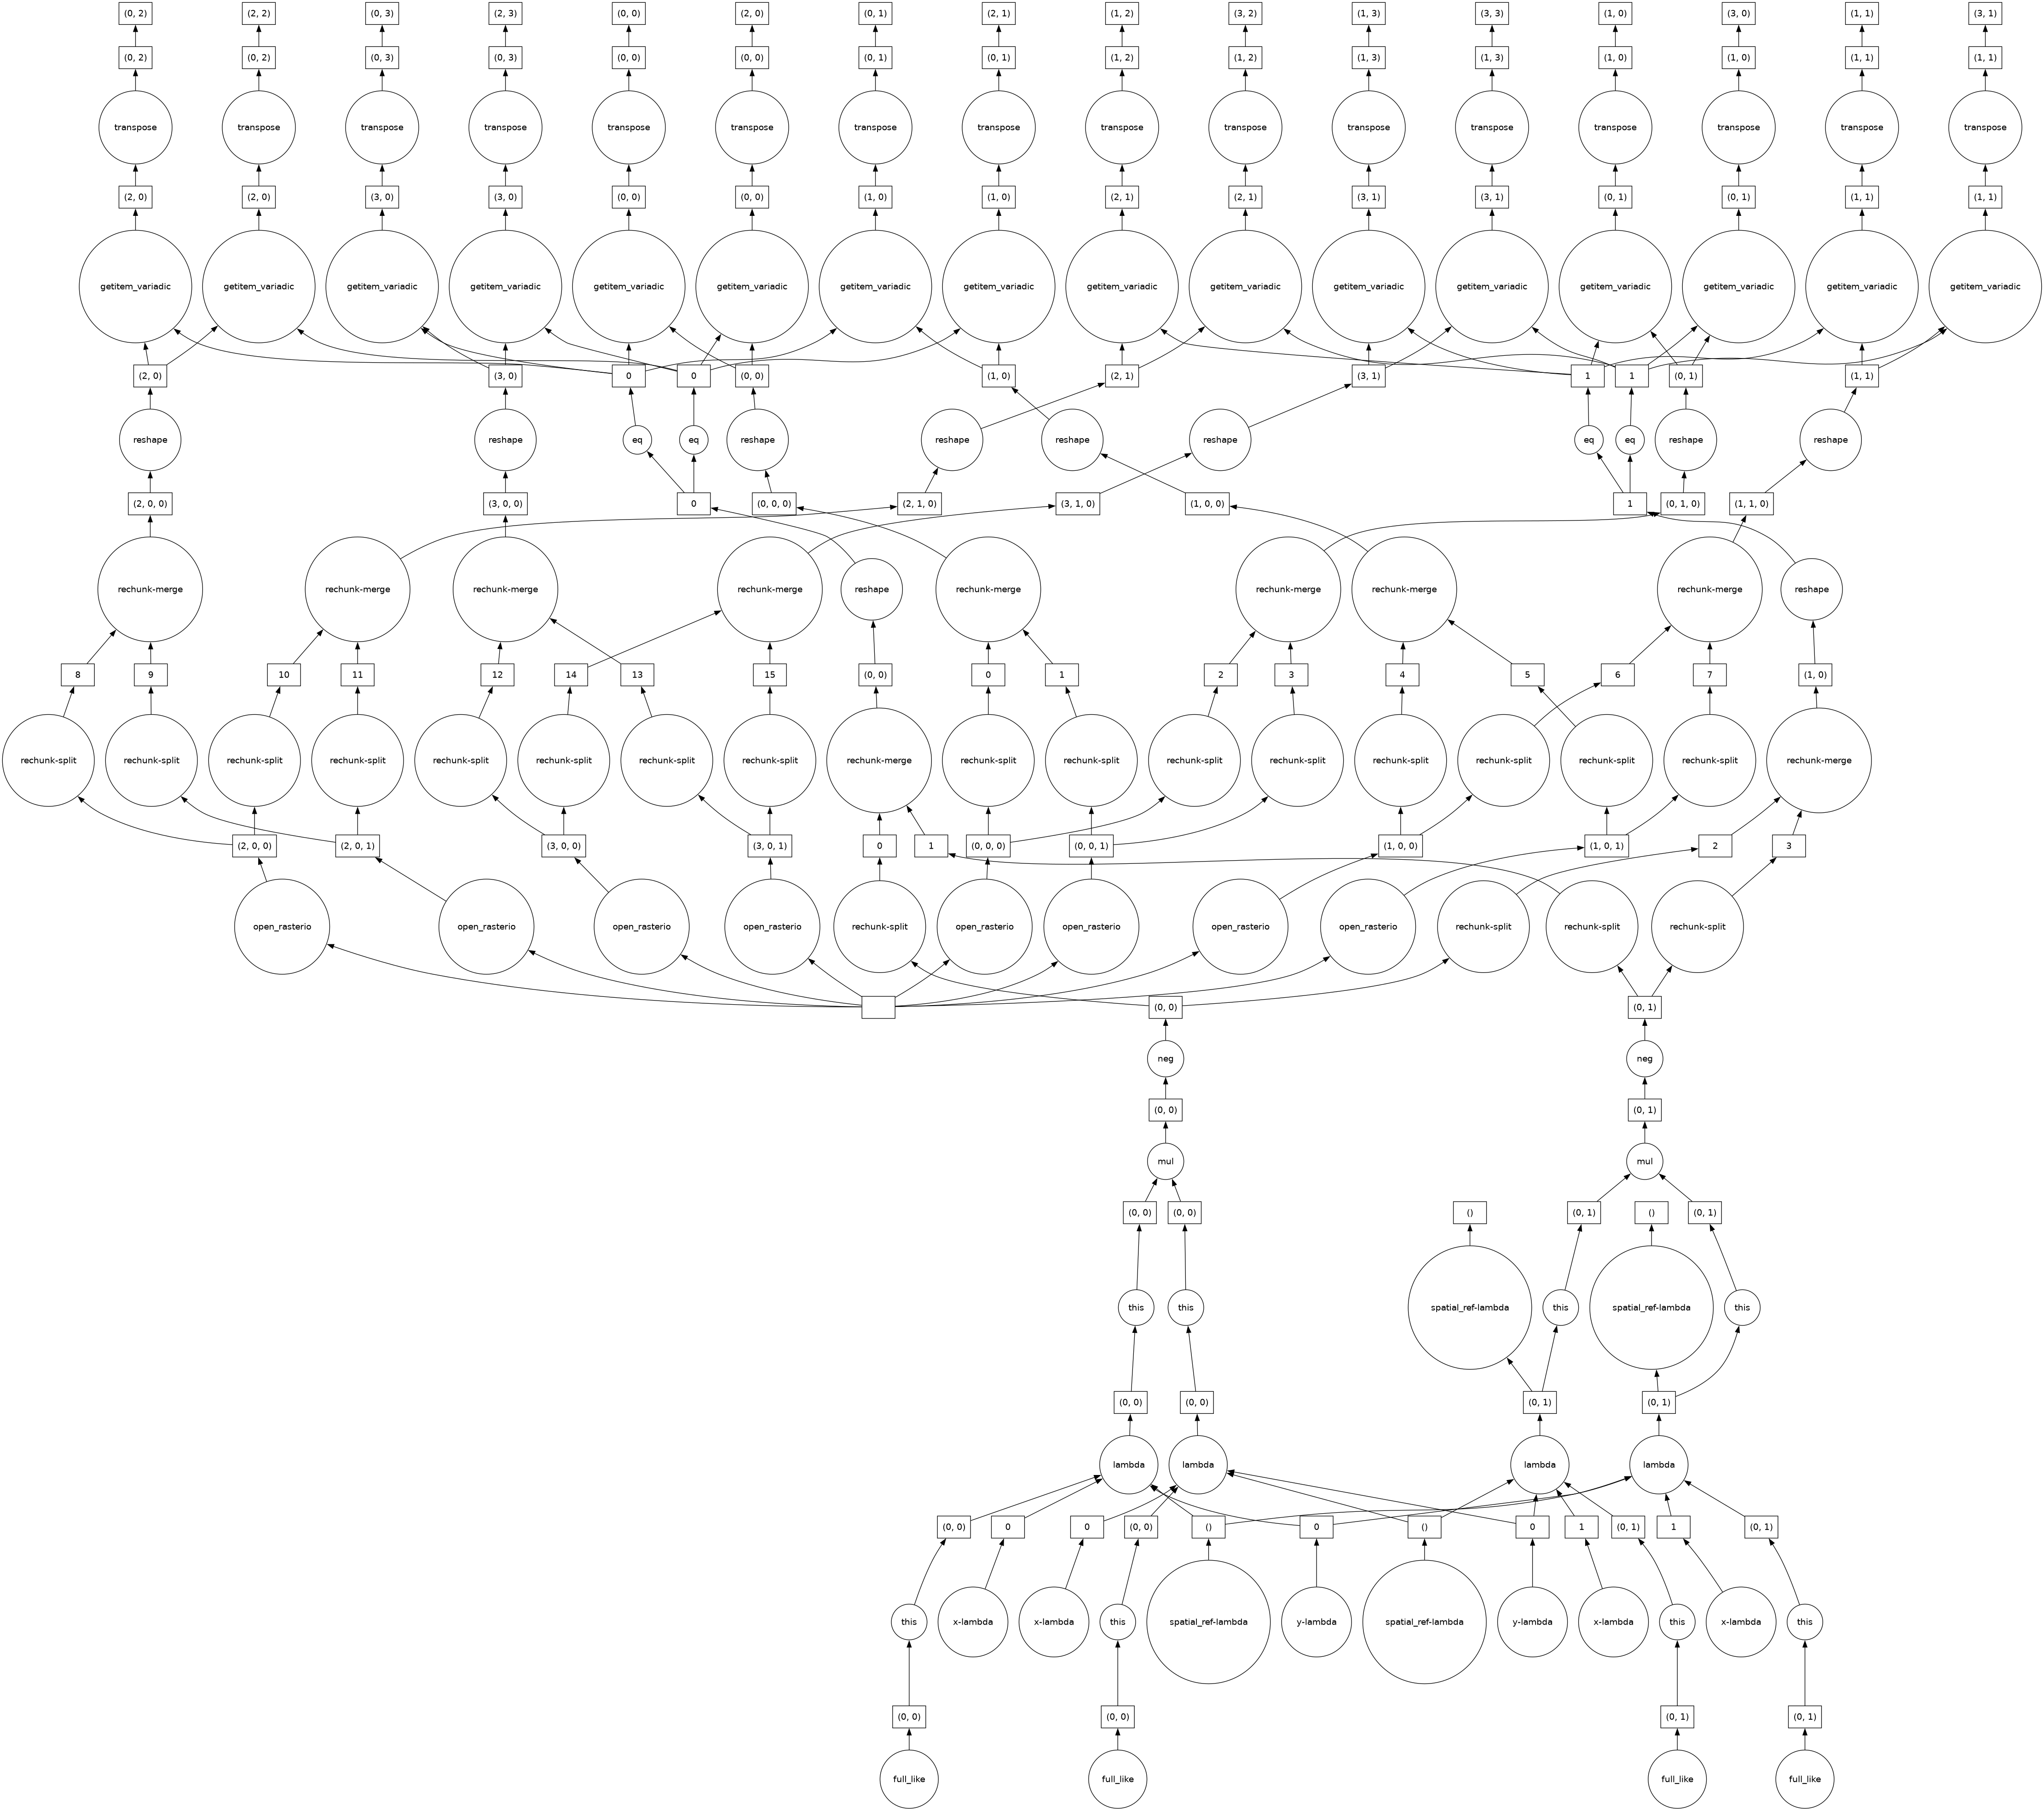

In [10]:
dask.visualize(train_data)

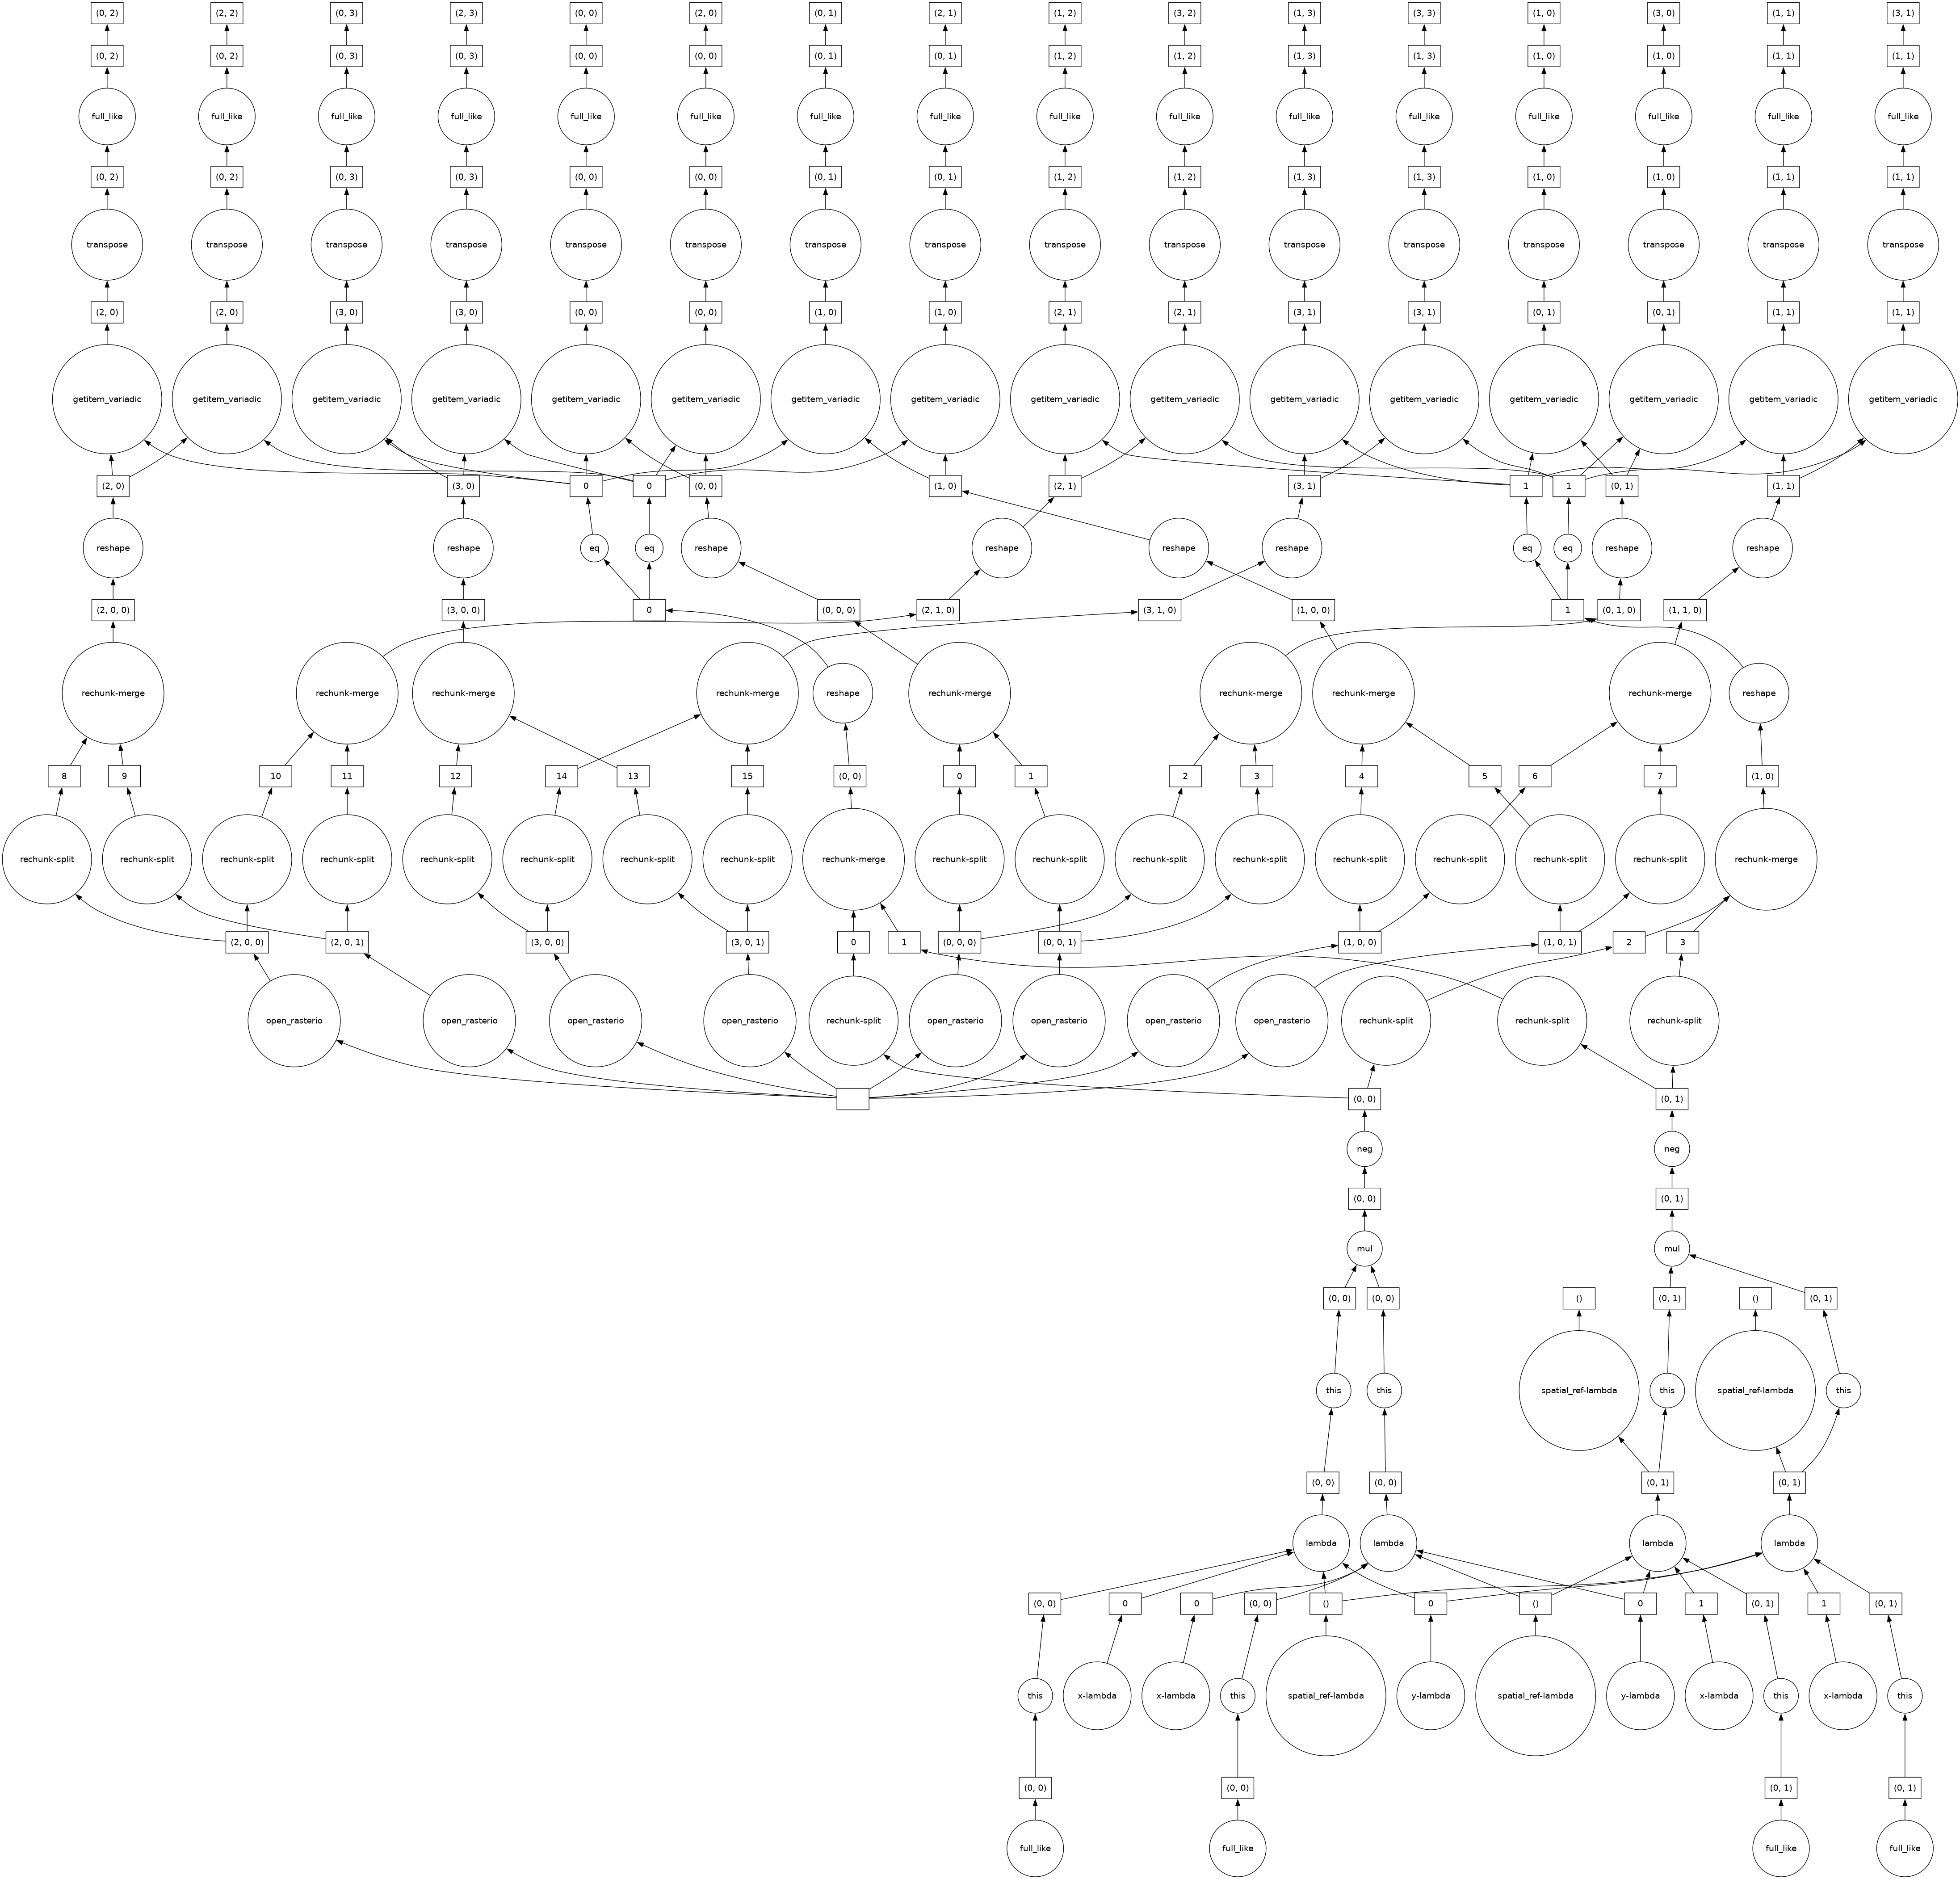

In [11]:
dask.visualize(train_labels)

## Train the RandomForestClassifier

In [12]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(train_data, train_labels)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Prediction

In [13]:
input = img.data.reshape((img.data.shape[0], -1)).transpose().rechunk((868780, 1))
input

dask.array<rechunk-merge, shape=(868780, 4), dtype=uint8, chunksize=(868780, 1), chunktype=numpy.ndarray>

In [14]:
# Prediction on each band
predictions = classifier.predict_proba(input)
predictions

[array([[0.32, 0.68],
        [0.32, 0.68],
        [0.32, 0.68],
        ...,
        [0.  , 1.  ],
        [0.  , 1.  ],
        [0.  , 1.  ]], shape=(868780, 2)),
 array([[0.32, 0.68],
        [0.32, 0.68],
        [0.32, 0.68],
        ...,
        [0.  , 1.  ],
        [0.  , 1.  ],
        [0.  , 1.  ]], shape=(868780, 2)),
 array([[0.32, 0.68],
        [0.32, 0.68],
        [0.32, 0.68],
        ...,
        [0.  , 1.  ],
        [0.  , 1.  ],
        [0.  , 1.  ]], shape=(868780, 2)),
 array([[0.32, 0.68],
        [0.32, 0.68],
        [0.32, 0.68],
        ...,
        [0.  , 1.  ],
        [0.  , 1.  ],
        [0.  , 1.  ]], shape=(868780, 2))]

In [15]:
# Map of possibilities, take one band for now
map = predictions[0].transpose().reshape((2, 718, 1210))

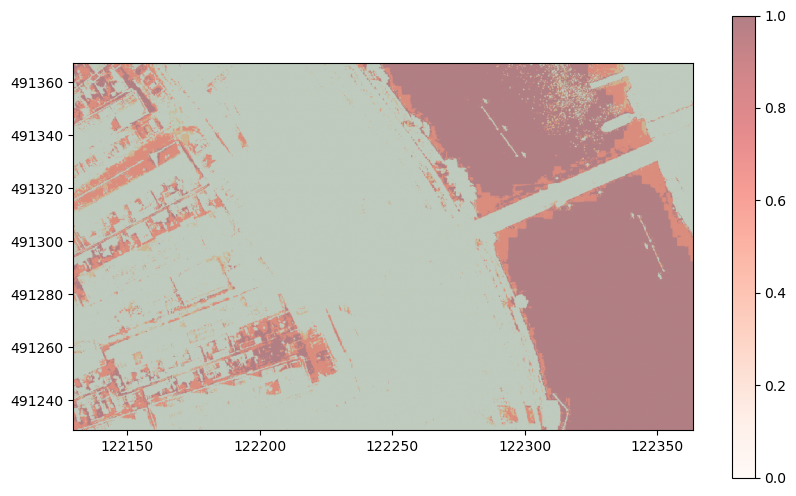

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(map[0], cmap='Greens', alpha=0.5, extent=(img.x.min(), img.x.max(), img.y.min(), img.y.max()))
plt.imshow(map[1], cmap='Reds', alpha=0.5, extent=(img.x.min(), img.x.max(), img.y.min(), img.y.max()))
plt.colorbar()